In [1]:
import numpy as np
import scipy.linalg as la
from scipy.integrate import odeint

import sympy as sp
import sympy.physics.mechanics as spm
from sympy.physics.mechanics import dynamicsymbols
spm.init_vprinting()

import matplotlib.pyplot as plt

import inverted_pendulum
import control as ct

## Simulation

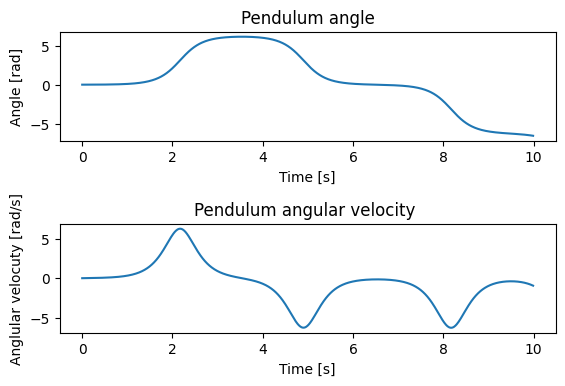

In [2]:
 # Parameters:
m = 10.
c = 0.1
ell = 1.
g = 9.8
L = ell

# Run simulation for tf seconds
tf = 10.  
dt = 0.01

# Initial conditions
theta_0 = 0.01
thetadot_0 = 0.
IC = np.array([theta_0, thetadot_0])  

# Step input
tau = 0.

# Run the simulation
t = np.arange(0., tf, step=dt )
trajectory = odeint(inverted_pendulum.Model, IC, t, args=(m, g, ell, c, tau),
               rtol=1e-4, atol=1e-5)

inverted_pendulum.plotter(trajectory,t)

# Linearize about operating point $\theta=180 °$

In [3]:
A = np.array([[0, 1],
            [-c/(m*ell**2), g/ell]])

B = np.array([0, 1/(m*ell**2)]).reshape(2, 1)

C = np.array([[1, 0]])

D = np.zeros([1,1])

### Create symbolic matrices

In [4]:
L_, m_, c_, g_ = sp.symbols('L m c g', real=True, positive=True)
k_1_, k_2_, k_f_, r_ = sp.symbols('k_1 k_2 k_f r')

gamma_ = sp.symbols('gamma_')

A_sym = sp.Matrix([[0, 1],
                   [-c_/(m_*L_**2), g_/L_]])

B_sym = sp.Matrix([0,  1/(m_*L_**2)])

K_sym = sp.Matrix([k_1_, k_2_]).T

In [5]:
B_sym

⎡ 0  ⎤
⎢    ⎥
⎢ 1  ⎥
⎢────⎥
⎢ 2  ⎥
⎣L ⋅m⎦

### Substitute values

In [6]:
A = A_sym.subs({c_:c, L_:L, m_:m, g_:g})
B = B_sym.subs({L_:L, m_:m,})
C = np.array([[1, 0]]).reshape(1,2)

A

⎡  0     1 ⎤
⎢          ⎥
⎣-0.01  9.8⎦

## Convert to numpy matrix

In [8]:
s=(c_,L_,m_,g_)

A_func =  sp.lambdify(s,A_sym, modules='numpy')
B_func =  sp.lambdify(s,B_sym, modules='numpy')

A = A_func(c,L,m,g)
B = B_func(c,L,m,g)
A

array([[ 0.  ,  1.  ],
       [-0.01,  9.8 ]])

## Check Reachability

In [9]:
# compute the controllability matrix
ctrb_matrix = ct.ctrb(A, B)

# check if the matrix is full column rank, ie, if rank(matrix)=number of columns

ctrb_result = True if np.linalg.matrix_rank(ctrb_matrix) == ctrb_matrix.shape[1] else False
print('Is controllable: ',ctrb_result)

Is controllable:  True


# State feedback

State feedback controller of the form $u = -KX$ where $K= [−15.3, 1730, − 50, 443]$ (from CDS 110 exercise)

In [10]:
K = np.array([ 1730, 330]).reshape(1, 2)
A_state_fb = A - np.matmul(B,K)

Check if the new system is stable, ie, if the the eigenvalues are all strictly negative

In [11]:
eigs = np.linalg.eigvals(A_state_fb)

ctrb_result = True if np.all(eigs.real<0) else False
print('Is stable: ',ctrb_result)
print('Real part of Eigenvalues: ', eigs.real)

Is stable:  True
Real part of Eigenvalues:  [-11.6 -11.6]


### Simulating the closed loop controller

In [12]:
def Pendulum_StateFeedback(q, t, A_state_fb):
    """cart-pendulum ODE
    """
    dq = np.matmul(A_state_fb,q.reshape(2,1))

    return dq.reshape(2)

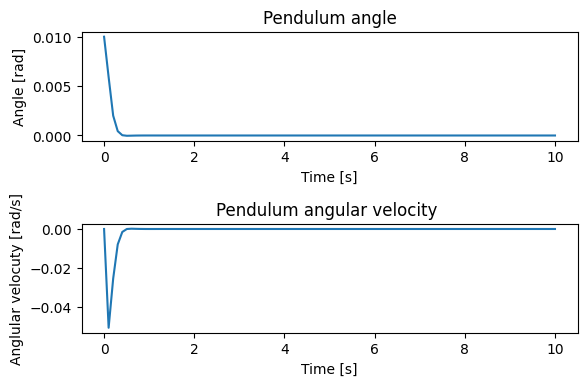

In [14]:
# Initial conditions
theta_0 = 0.01
thetadot_0 = 0.
IC = np.array([theta_0, thetadot_0])  

# Step input
tau = 0.

# Run the simulation
t = np.arange(0., tf, step=dt )
trajectory = odeint(inverted_pendulum.Model, IC, t, args=(m, g, ell, c, tau),
               rtol=1e-4, atol=1e-5)

# Step input
f = 1.

# Run the simulation
t = np.linspace(0, tf, 100)
trajectory = odeint(Pendulum_StateFeedback, IC, t, args=(A_state_fb,),
               rtol=1e-4, atol=1e-5)

# Plot the data
inverted_pendulum.plotter(trajectory,t)

### Convert to Reachable canonical form

In [16]:
# create state space system
sys = ct.ss(A_state_fb,B,C,D)

zsys,T = ct.canonical_form(sys, form='reachable')
zsys

StateSpace(array([[ -23.2 , -173.01],
       [   1.  ,    0.  ]]), array([[1.],
       [0.]]), array([[0. , 0.1]]), array([[0.]]))

### Pole / Eigenvalue Placement

We know that the secod order systems can be represented in the for $ \lambda^2 + 2\zeta\omega_n\lambda + \omega_n^2 $. Comparing with tht characteristic polynomial, we see that $2\zeta\omega_n = \gamma k_1 + k_2$ and $k_1=\omega_n^2$

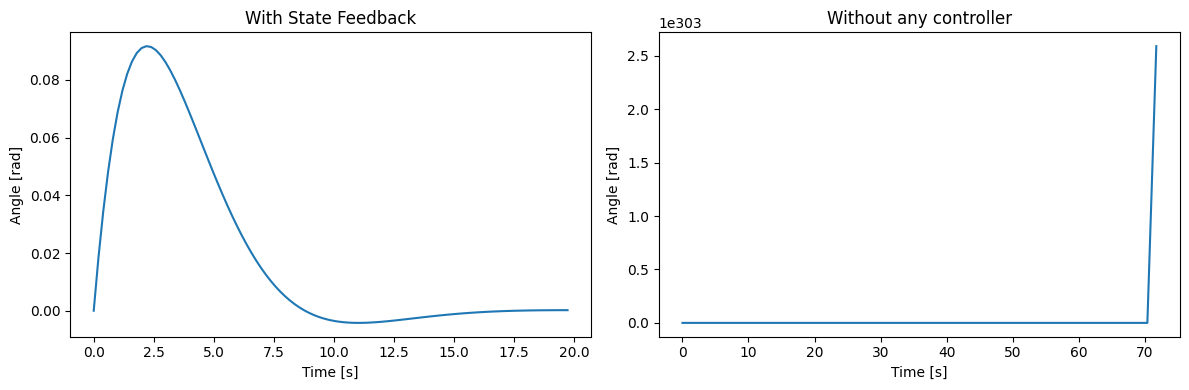

In [26]:
# desired parameters
zeta= 0.7
w_n= 0.5

# compute eigenvalues for the desired system  
coeff = [1., 2.*zeta*w_n, w_n**2]
desired_eig = np.roots(coeff)

# compute gain matrix K such that (A-BK) has the desired eigenvalues 
K = ct.place(A, B, desired_eig)

# compute new dynamics matrix with state feedback: (A-BK)
A_state_fb = A - B*K
# np.linalg.eigvals(A_state_fb)

# controlled system
sys_c = ct.ss(A_state_fb,B,C,D)
T_c, yout_c = ct.impulse_response(sys_c)

# uncontrolled system
sys_uc = ct.ss(A,B,C,D)
T_uc, yout_uc = ct.impulse_response(sys_uc)

# Plot the data
fig, axs = plt.subplots(1,2, figsize=(12, 4))

# impulse reponse of the controlled system
axs[0].plot(T_c, yout_c)

# impulse reponse of the uncontrolled system
axs[1].plot(T_uc, yout_uc)

# Format the plot
axs[0].set_title("With State Feedback")
axs[0].set_ylabel('Angle [rad]')
axs[0].set_xlabel('Time [s]')

axs[1].set_title("Without any controller")
axs[1].set_ylabel('Angle [rad]')
axs[1].set_xlabel('Time [s]')
plt.tight_layout()

### Adding feedfoward gain $k_f$ so that the system has DC gain=1 (DC Gain: gain when then input frequency is zero ,ie, magn(step response)/ magn(step input)

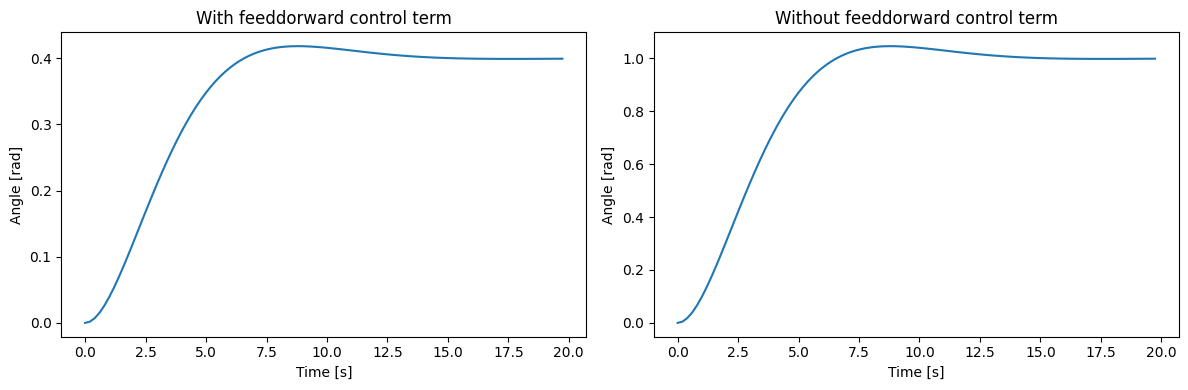

In [29]:
# comput DC gain (gain at zero input frequency)
dc_gain = sys_c(0)

# compute k_f
k_f = np.real(1/dc_gain)

# controlled system with feedforward gain
sys_cff = ct.ss(A_state_fb, B*k_f, C, D)

# step reponse with feedforward term
T_c, yout_c = ct.step_response(sys_c)

# step reponse without feedforward term
T_cff, yout_cff = ct.step_response(sys_cff)

# Plot the data
fig, axs = plt.subplots(1,2, figsize=(12, 4))


# impulse reponse of the controlled system
axs[0].plot(T_c, yout_c)

# impulse reponse of the uncontrolled system
axs[1].plot(T_cff, yout_cff)

# Format the plot
axs[0].set_title("With feeddorward control term")
axs[0].set_ylabel('Angle [rad]')
axs[0].set_xlabel('Time [s]')

axs[1].set_title("Without feeddorward control term")
axs[1].set_ylabel('Angle [rad]')
axs[1].set_xlabel('Time [s]')
plt.tight_layout()